# Cifar-10 : Computer Vision Classification

In [ ]:
#!pip install numpy==1.26.4

In [163]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.ops as ops
import pandas as pd

import random

import pickle

from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
#tfds.list_builders()

In [2]:
(data_train, data_test, data_val), infos = tfds.load('cifar10',split=['train[:48000]','train[48000:]+test[:4000]','test[4000:]'], shuffle_files=True, # 80/10/10%
                      as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.0AGEL1_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.0AGEL1_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Explore data :

In [3]:
class_names=infos.features['label'].names

In [ ]:
data_train.cardinality(), data_test.cardinality(), data_val.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=48000>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6000>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6000>)

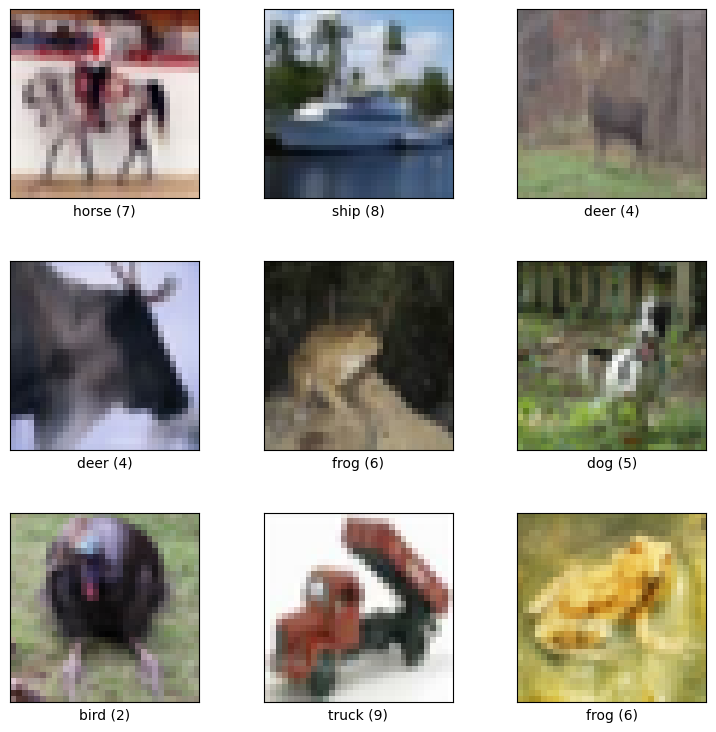

In [ ]:
tfds.show_examples(data_train,infos);

In [ ]:
for image, label in data_train.take(1):
    print(image.dtype)
    print(image.numpy().min())
    print(image.numpy().max())

<dtype: 'uint8'>
0
249


## Preprocessing :

### Rescale, Resize, Batch :

In [4]:
# Preprocessing data : ensure they all have the same size (32x32x3), datas are scaled [0,1] and type float32
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(32,32),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2)
])

data_augmentation_01 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomHeight(0.1),
  tf.keras.layers.RandomWidth(0.1)
])

def preprocess(data, val=0, augment=False) :
  data = data.shuffle(buffer_size=1000) #Shuffle data

  if augment and val==0.1:
    data=data.map(lambda x, y: (data_augmentation_01(x), y), num_parallel_calls=tf.data.AUTOTUNE) #Augment if necessary

  if augment and val==0.2:
    data=data.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE) #Augment if necessary

  data=data.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE) #Resize, rescale

  data=data.batch(64) # Batch de 64, CHOIX

  return data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
batch_train=preprocess(data_train)
batch_test=preprocess(data_test)
batch_val=preprocess(data_val)

batch_train, batch_test, batch_val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
aug_train=preprocess(data_train,augment=True, val=0.2)

aug_train_01=preprocess(data_train,augment=True, val=0.1)

### Visualisation :

(-0.5, 31.5, 31.5, -0.5)

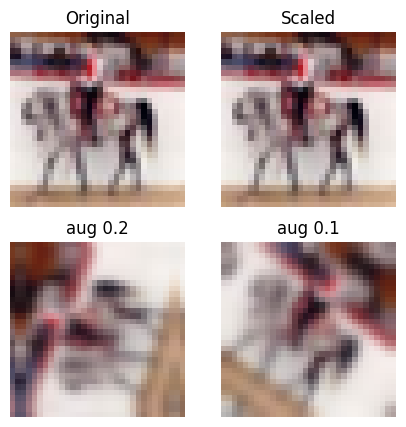

In [ ]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)
plt.imshow(image)
plt.title('Original')
plt.axis(False)

plt.subplot(2,2,2)
plt.imshow(resize_rescale(image))
plt.title('Scaled')
plt.axis(False)

plt.subplot(2,2,3)
plt.imshow(resize_rescale(data_augmentation(image)))
plt.title('aug 0.2')
plt.axis(False)

plt.subplot(2,2,4)
plt.imshow(resize_rescale(data_augmentation_01(image)))
plt.title('aug 0.1')
plt.axis(False)

## Modelling :

In [44]:
# Enable mixed precision training : Better use of GPU's Memory by using lfoat32 and float16 when possible
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [45]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [ ]:
checkpoint_path="best_model_cifar10.weights.h5"

# Callbacks :

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

LrReducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7) # Only when the val_loss doesn't go down for 2 epochs

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='max')

### Baseline & data augmentation or not :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'), # One bloc only
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0=model_0.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
  2/750 ━━━━━━━━━━━━━━━━━━━━ 57:21 5s/step - accuracy: 0.1133 - loss: 2.4264  

KeyboardInterrupt: 

In [ ]:
model_0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,940 (124.78 KB)

 Trainable params: 10,602 (41.41 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 21,210 (82.86 KB)

In [ ]:
res_0=model_0.evaluate(batch_test) # 65% accuracy

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6785 - loss: 0.9115


[0.922683596611023, 0.6775000095367432]

In [ ]:
df_0=pd.DataFrame(history_0.history).drop('learning_rate',axis=1)
df_0.columns=['accuracy_0','loss_0','val_accuracy_0','val_loss_0']
df_0_acc=df_0.loc[:,['accuracy_0','val_accuracy_0']]
df_0_loss=df_0.loc[:,['loss_0','val_loss_0']]

In [ ]:
model_0.save('model_0.keras')

with open('history_0', 'wb') as f:
    pickle.dump(history_0.history, f)

#### With data augmentation (val=0.2) :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_aug=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_0_aug.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0_aug=model_0_aug.fit(aug_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint]) # data augmentation

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.2884 - loss: 1.9637 - val_accuracy: 0.3045 - val_loss: 2.0135 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 114ms/step - accuracy: 0.3761 - loss: 1.7503 - val_accuracy: 0.2693 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4086 - loss: 1.6691
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 88ms/step - accuracy: 0.4086 - loss: 1.6691 - val_accuracy: 0.3005 - val_loss: 2.5441 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 80ms/step - accuracy: 0.4376 - loss: 1.5971 - val_accuracy: 0.3562 - val_loss: 1.9747 - learning_rate: 2.0000e-04
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.4480 - loss: 1.5688 - val_accuracy: 0.3938 - val_loss: 1.8054 - learning_rate: 2.0000e-04
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.

In [ ]:
model_0_aug.evaluate(batch_test) # 41% accuracy

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4171 - loss: 1.7773


[1.7778533697128296, 0.4176666736602783]

The data augmentation with val=0.2 doesn't help with generalization at all it even worsen the learning.

In [ ]:
del model_0_aug, history_0_aug, aug_train

#### With data augmentation (val=0.1) :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_aug01=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_0_aug01.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0_aug01=model_0_aug01.fit(aug_train_01,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint]) # Data augmentation

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.3032 - loss: 1.9204 - val_accuracy: 0.2125 - val_loss: 2.9016 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.4178 - loss: 1.6186 - val_accuracy: 0.2498 - val_loss: 3.2168 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.4557 - loss: 1.5278 - val_accuracy: 0.3653 - val_loss: 2.1279 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.4708 - loss: 1.4745 - val_accuracy: 0.4150 - val_loss: 1.8120 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.4909 - loss: 1.4300 - val_accuracy: 0.3400 - val_loss: 2.3549 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5041 - loss: 1.4009
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.5041 - lo

In [ ]:
model_0_aug01.evaluate(batch_test) # 50% accuracy

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 1.5467


[1.5488076210021973, 0.5016666650772095]

#### Conclusion :

<Axes: >

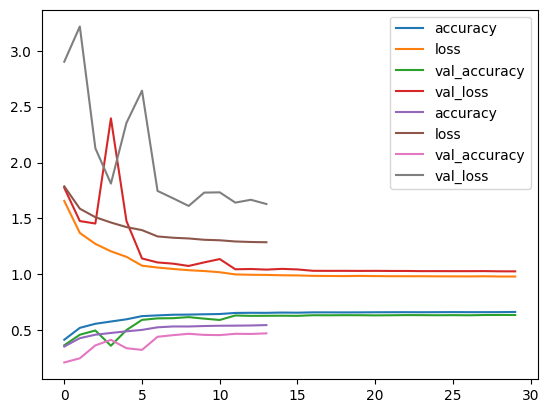

In [ ]:
pd.concat([pd.DataFrame(history_0.history).drop('learning_rate',axis=1),pd.DataFrame(history_0_aug01.history).drop('learning_rate',axis=1)],axis=1).plot()

Data augmentation doesn't help with generalization and worsen the learning in general. The benchmark for amelioration is model_0 (68% accuracy).

In [ ]:
del aug_train_01, model_0_aug01, history_0_aug01, data_augmentation_01

NameError: name 'model_0_aug01' is not defined

### Valid vs same padding

#### Valid :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_valid=tf.keras.Sequential([ #Same architecture as previously
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='valid'), # using valid padding
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_0_valid.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0_valid=model_0_valid.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3600 - loss: 1.7968 - val_accuracy: 0.3540 - val_loss: 1.8195 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5157 - loss: 1.3821 - val_accuracy: 0.4525 - val_loss: 1.5364 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5529 - loss: 1.2810 - val_accuracy: 0.5068 - val_loss: 1.3469 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5721 - loss: 1.2197 - val_accuracy: 0.4807 - val_loss: 1.4391 - learning_rate: 0.0010
Epoch 5/30
743/750 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5929 - loss: 1.1713
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5929 - loss: 1.1712 - val_accuracy: 0.4488 - val_loss: 1.8350 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6206 - loss: 1.0964 - 

In [ ]:
model_0_valid.evaluate(batch_test) # 64%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6401 - loss: 1.0181


[0.9994584321975708, 0.6483333110809326]

#### Conclusion  :

In [ ]:
df_valid=pd.DataFrame(history_0_valid.history).drop('learning_rate',axis=1)
df_valid.columns=['accuracy_valid','loss_valid','val_accuracy_valid','val_loss_valid']
df_valid_acc=df_valid.loc[:,['accuracy_valid','val_accuracy_valid']]
df_valid_loss=df_valid.loc[:,['loss_valid','val_loss_valid']]

NameError: name 'history_0_valid' is not defined

<Axes: >

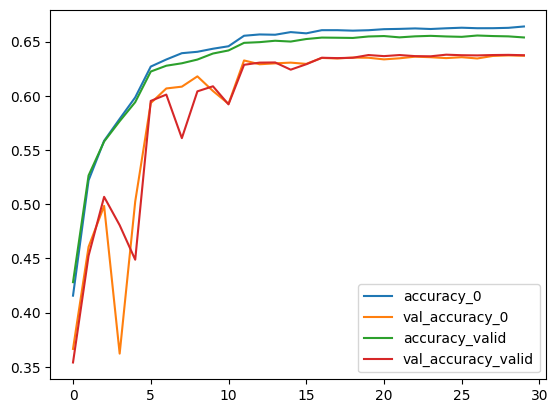

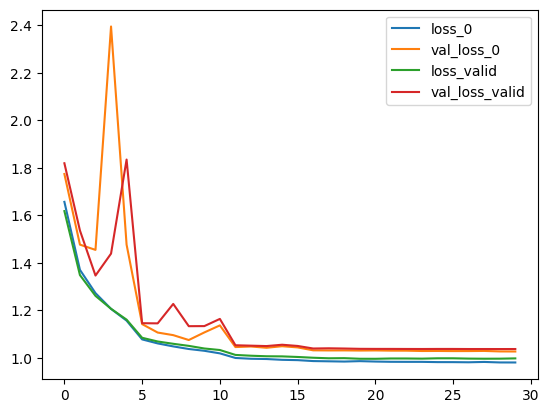

In [ ]:
pd.concat([df_0_acc,df_valid_acc],axis=1).plot()
pd.concat([df_0_loss,df_valid_loss],axis=1).plot()

Same padding seems to be better in loss and accuraccy in this case but they're close to each other.

In [ ]:
del model_0_valid, history_0_valid, df_valid, df_valid_acc, df_valid_loss

### Relu vs tanh vs sigmoid

#### Sigmoid :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_sig=tf.keras.Sequential([ #Same architecture as previously
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='sigmoid', padding='same'), # using sigmoid activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='sigmoid', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_0_sig.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0_sig=model_0_sig.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2670 - loss: 2.0291 - val_accuracy: 0.3060 - val_loss: 1.8831 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4106 - loss: 1.6743 - val_accuracy: 0.2712 - val_loss: 2.0550 - learning_rate: 0.0010
Epoch 3/30
741/750 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4638 - loss: 1.5220
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4639 - loss: 1.5216 - val_accuracy: 0.2505 - val_loss: 2.7659 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4979 - loss: 1.4411 - val_accuracy: 0.4722 - val_loss: 1.4925 - learning_rate: 2.0000e-04
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5054 - loss: 1.4215 - val_accuracy: 0.4865 - val_loss: 1.4463 - learning_rate: 2.0000e-04
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5105 - loss

In [ ]:
model_0_sig.evaluate(batch_test) # 53%

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5383 - loss: 1.3112


[1.306646466255188, 0.5381666421890259]

#### Tanh :

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_tanh=tf.keras.Sequential([ #Same architecture as previously
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='tanh', padding='same'), # using tanh activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='tanh', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_0_tanh.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0_tanh=model_0_tanh.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2768 - loss: 2.0033 - val_accuracy: 0.2533 - val_loss: 2.0950 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4225 - loss: 1.6465 - val_accuracy: 0.2312 - val_loss: 2.4792 - learning_rate: 0.0010
Epoch 3/30
745/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4768 - loss: 1.4835
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4769 - loss: 1.4833 - val_accuracy: 0.2875 - val_loss: 2.4775 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5110 - loss: 1.3983 - val_accuracy: 0.4977 - val_loss: 1.4203 - learning_rate: 2.0000e-04
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5202 - loss: 1.3775 - val_accuracy: 0.5103 - val_loss: 1.3821 - learning_rate: 2.0000e-04
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5255 - loss:

In [ ]:
model_0_tanh.evaluate(batch_test) # 55%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5526 - loss: 1.2652


[1.2585209608078003, 0.5571666955947876]

#### Conclusion :

In [ ]:
df_sig=pd.DataFrame(history_0_sig.history).drop('learning_rate',axis=1)
df_sig.columns=['accuracy_sig','loss_sig','val_accuracy_sig','val_loss_sig']
df_sig_acc=df_sig.loc[:,['accuracy_sig','val_accuracy_sig']]
df_sig_loss=df_sig.loc[:,['loss_sig','val_loss_sig']]

df_tanh=pd.DataFrame(history_0_tanh.history).drop('learning_rate',axis=1)
df_tanh.columns=['accuracy_tanh','loss_tanh','val_accuracy_tanh','val_loss_tanh']
df_tanh_acc=df_tanh.loc[:,['accuracy_tanh','val_accuracy_tanh']]
df_tanh_loss=df_tanh.loc[:,['loss_tanh','val_loss_tanh']]

<Axes: >

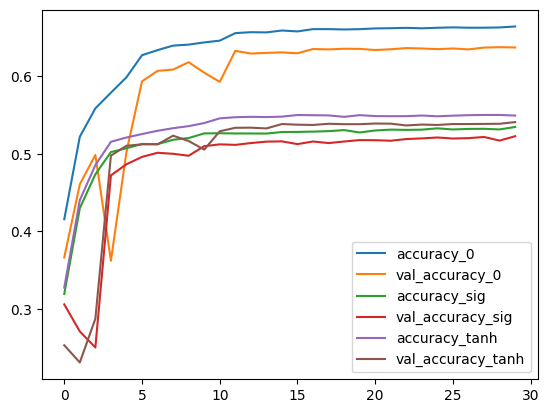

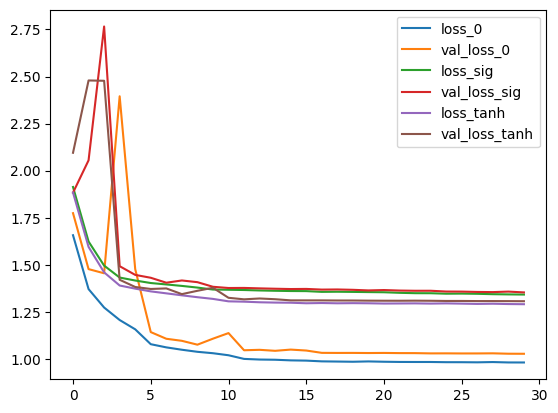

In [ ]:
pd.concat([df_0_acc,df_sig_acc,df_tanh_acc],axis=1).plot()
pd.concat([df_0_loss,df_sig_loss,df_tanh_loss],axis=1).plot()

ReLU is the best option here.

In [ ]:
del model_0_sig, history_0_sig, model_0_tanh, history_0_tanh, df_sig, df_sig_acc, df_sig_loss, df_tanh, df_tanh_acc, df_tanh_loss

### Adam vs AdamW

#### AdamW

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_0_adamw=tf.keras.Sequential([ #Same architecture as previously
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_0_adamw.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.AdamW(weight_decay=0.004), #AdamW with decay=0.004, the default
                metrics=['accuracy'])

history_0_adamw=model_0_adamw.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3459 - loss: 1.8306 - val_accuracy: 0.3845 - val_loss: 1.7219 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5123 - loss: 1.4035 - val_accuracy: 0.3368 - val_loss: 2.0234 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5482 - loss: 1.2915 - val_accuracy: 0.4900 - val_loss: 1.4713 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5776 - loss: 1.2219 - val_accuracy: 0.5430 - val_loss: 1.2948 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5962 - loss: 1.1665 - val_accuracy: 0.4690 - val_loss: 1.6123 - learning_rate: 0.0010
Epoch 6/30
741/750 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6019 - loss: 1.1327
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6019 - loss: 1.1326 

In [ ]:
model_0_adamw.evaluate(batch_test) # 66%

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6602 - loss: 0.9851


[0.9823800325393677, 0.6598333120346069]

#### Conclusion :

In [ ]:
df_adamw=pd.DataFrame(history_0_adamw.history).drop('learning_rate',axis=1)
df_adamw.columns=['accuracy_adamw','loss_adamw','val_accuracy_adamw','val_loss_adamw']
df_adamw_acc=df_adamw.loc[:,['accuracy_adamw','val_accuracy_adamw']]
df_adamw_loss=df_adamw.loc[:,['loss_adamw','val_loss_adamw']]

<Axes: >

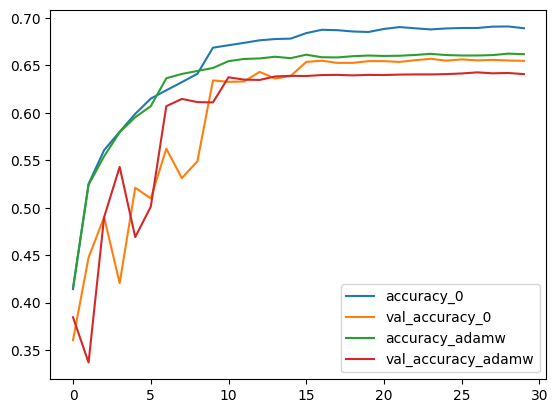

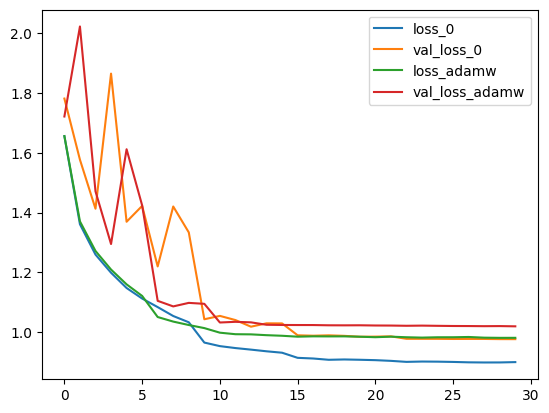

In [ ]:
pd.concat([df_0_acc,df_adamw_acc],axis=1).plot()
pd.concat([df_0_loss,df_adamw_loss],axis=1).plot()

Adam is better here.

### Architecture (Can start from here) :

In [ ]:
model_0 = tf.keras.models.load_model('model_0.keras')

with open('history_0', "rb") as f:
    history_0 = pickle.load(f)

df_0=pd.DataFrame(history_0).drop('learning_rate',axis=1)
df_0.columns=['accuracy_0','loss_0','val_accuracy_0','val_loss_0']
df_0_acc=df_0.loc[:,['accuracy_0','val_accuracy_0']]
df_0_loss=df_0.loc[:,['loss_0','val_loss_0']]

#### Model 1 : 1 Bloc 64 filters

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_1=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'), #More filter in the bloc 32->64
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1=model_1.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3730 - loss: 1.7518 - val_accuracy: 0.4033 - val_loss: 1.6070 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5391 - loss: 1.3253 - val_accuracy: 0.3628 - val_loss: 2.2250 - learning_rate: 0.0010
Epoch 3/30
743/750 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5873 - loss: 1.1955
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5873 - loss: 1.1953 - val_accuracy: 0.2790 - val_loss: 3.3323 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6286 - loss: 1.0805 - val_accuracy: 0.6083 - val_loss: 1.1141 - learning_rate: 2.0000e-04
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6473 - loss: 1.0370 - val_accuracy: 0.6193 - val_loss: 1.1008 - learning_rate: 2.0000e-04
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6546 - loss

In [ ]:
res_1=model_1.evaluate(batch_test) #70%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7024 - loss: 0.8625


[0.8636119961738586, 0.703000009059906]

In [ ]:
df_1 = pd.DataFrame(history_1.history).drop('learning_rate',axis=1)
df_1.columns=['accuracy_1','loss_1','val_accuracy_1','val_loss_1']
df_1_acc=df_1.loc[:,['accuracy_1','val_accuracy_1']]
df_1_loss=df_1.loc[:,['loss_1','val_loss_1']]

<Axes: >

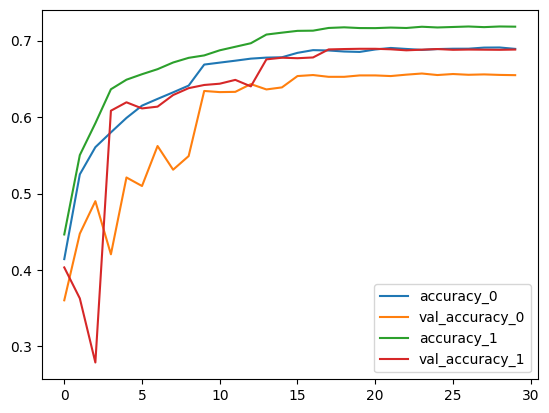

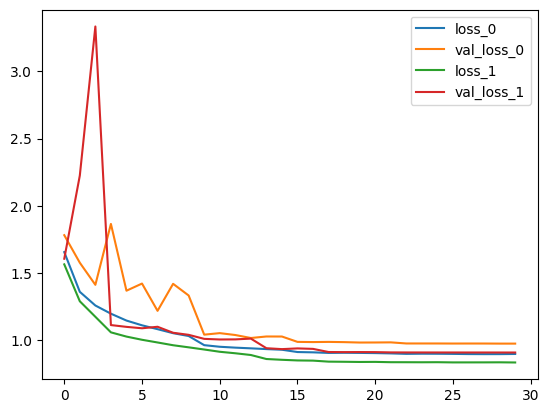

In [ ]:
pd.concat([df_0_acc,df_1_acc],axis=1).plot()
pd.concat([df_0_loss,df_1_loss],axis=1).plot()

64 filters is better than 32 filters, converge faster and better accuracy.

In [ ]:
model_1.save('model_1.keras')

with open('history_1', 'wb') as f:
    pickle.dump(history_1.history, f)

#### Model 2 : 2 Blocs 32->64 filters

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_2=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),


    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'), #Another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)

])

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_2=model_2.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.4577 - loss: 1.5194 - val_accuracy: 0.4868 - val_loss: 1.4915 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6523 - loss: 0.9979 - val_accuracy: 0.6312 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7098 - loss: 0.8393 - val_accuracy: 0.5012 - val_loss: 1.5387 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7486 - loss: 0.7346 - val_accuracy: 0.7048 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7747 - loss: 0.6577 - val_accuracy: 0.6555 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 6/30
741/750 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7975 - loss: 0.6013
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7975 - loss: 0.6010 -

In [ ]:
res_2=model_2.evaluate(batch_test) # 81%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8119 - loss: 0.5341 


[0.5504686236381531, 0.8096666932106018]

In [ ]:
df_2 = pd.DataFrame(history_2.history).drop('learning_rate',axis=1)
df_2.columns=['accuracy_2','loss_2','val_accuracy_2','val_loss_2']
df_2_acc=df_2.loc[:,['accuracy_2','val_accuracy_2']]
df_2_loss=df_2.loc[:,['loss_2','val_loss_2']]

<Axes: >

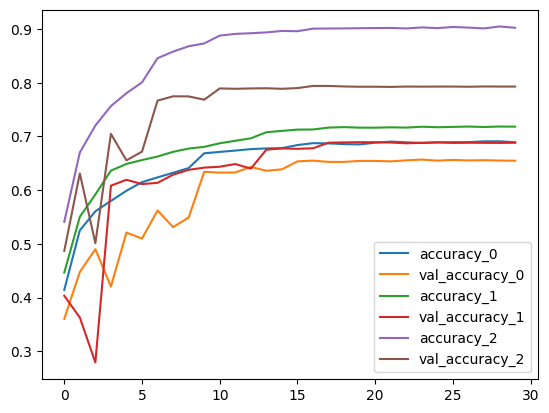

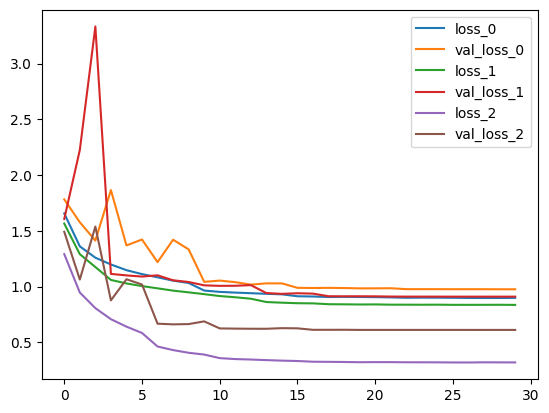

In [ ]:
pd.concat([df_0_acc,df_1_acc,df_2_acc],axis=1).plot()
pd.concat([df_0_loss,df_1_loss,df_2_loss],axis=1).plot()

In [ ]:
model_2.save('model_2.keras')

with open('history_2', 'wb') as f:
    pickle.dump(history_2.history, f)

#### Model 3 : 3 Blocs 32->64->128 filters

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_3=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_3=model_3.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.4894 - loss: 1.4683 - val_accuracy: 0.6548 - val_loss: 0.9788 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7178 - loss: 0.8119 - val_accuracy: 0.5747 - val_loss: 1.3201 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7844 - loss: 0.6245 - val_accuracy: 0.7340 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8238 - loss: 0.5079 - val_accuracy: 0.7647 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8601 - loss: 0.4071 - val_accuracy: 0.7632 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 6/30
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8898 - loss: 0.3235
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8898 - loss: 0.32

In [ ]:
res_3=model_3.evaluate(batch_test) # 85%

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8499 - loss: 0.5009


[0.5096136927604675, 0.8478333353996277]

In [ ]:
df_3 = pd.DataFrame(history_3.history).drop('learning_rate',axis=1)
df_3.columns=['accuracy_3','loss_3','val_accuracy_3','val_loss_3']
df_3_acc=df_3.loc[:,['accuracy_3','val_accuracy_3']]
df_3_loss=df_3.loc[:,['loss_3','val_loss_3']]

<Axes: >

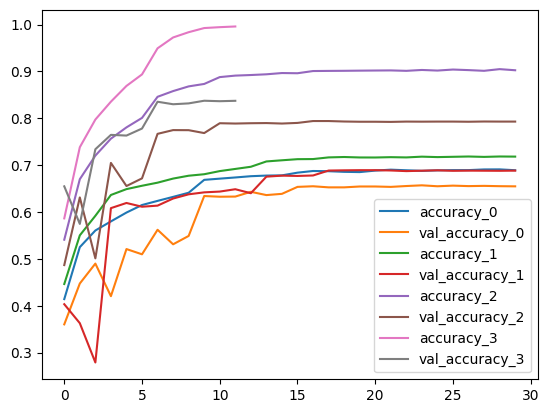

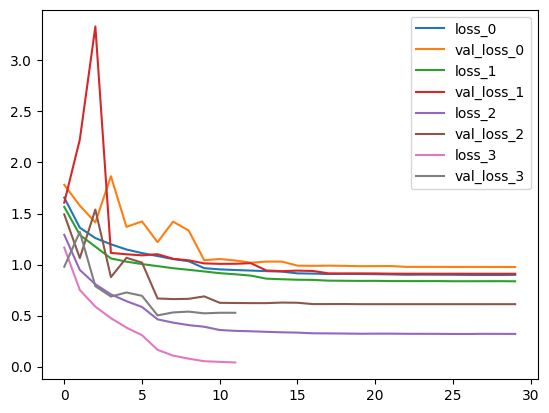

In [ ]:
pd.concat([df_0_acc,df_1_acc,df_2_acc,df_3_acc],axis=1).plot()
pd.concat([df_0_loss,df_1_loss,df_2_loss,df_3_loss],axis=1).plot()

Model start to overfit, i'll try to add dropout after convolution to see if it helps. I can stop following model 0 and 1.

In [ ]:
model_3.save('model_3.keras')

with open('history_3', 'wb') as f:
    pickle.dump(history_3.history, f)

#### Model 4 : 3 blocs and dropout (best model in the end)

In [47]:
tf.random.set_seed(42)
random.seed(42)

model_4=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_4=model_4.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
  3/750 ━━━━━━━━━━━━━━━━━━━━ 5:32:48 27s/step - accuracy: 0.1102 - loss: 3.1706

KeyboardInterrupt: 

In [ ]:
res_4=model_4.evaluate(batch_test) # 87%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8715 - loss: 0.3959


[0.41116219758987427, 0.8681666851043701]

In [ ]:
df_4 = pd.DataFrame(history_4.history).drop('learning_rate',axis=1)
df_4.columns=['accuracy_4','loss_4','val_accuracy_4','val_loss_4']
df_4_acc=df_4.loc[:,['accuracy_4','val_accuracy_4']]
df_4_loss=df_4.loc[:,['loss_4','val_loss_4']]

<Axes: >

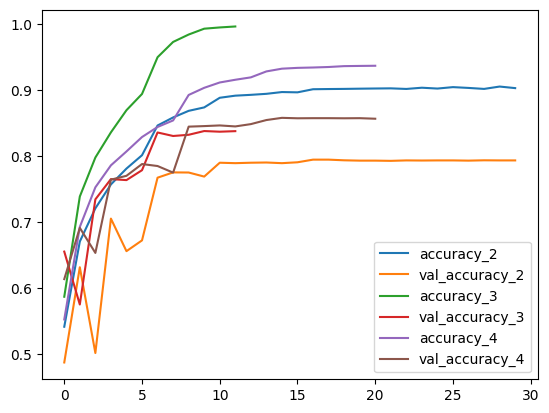

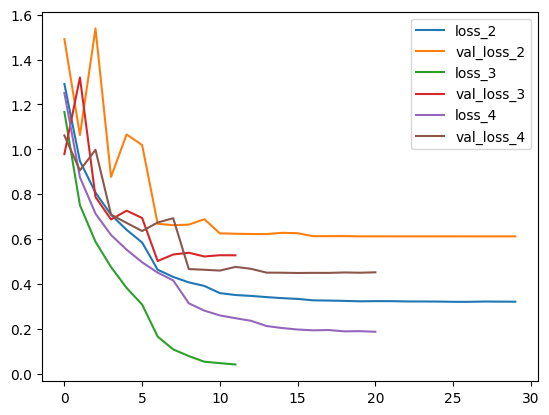

In [ ]:
pd.concat([df_2_acc,df_3_acc,df_4_acc],axis=1).plot()
pd.concat([df_2_loss,df_3_loss,df_4_loss],axis=1).plot()

In [ ]:
model_4.save('model_4.keras')

with open('history_4', 'wb') as f:
    pickle.dump(history_4.history, f)

Model 4 is a bit better in validation and with less overfitting here it seems.

#### Model 5 : Dropout after the GlobalAveragePooling

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_5=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_5=model_5.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4490 - loss: 1.6060 - val_accuracy: 0.5370 - val_loss: 1.4358 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6970 - loss: 0.8681 - val_accuracy: 0.6803 - val_loss: 0.9179 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7659 - loss: 0.6864 - val_accuracy: 0.7257 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8026 - loss: 0.5729 - val_accuracy: 0.7145 - val_loss: 0.8411 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8362 - loss: 0.4793 - val_accuracy: 0.7662 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8622 - loss: 0.4036 - val_accuracy: 0.7425 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8737 - loss: 0.3

In [ ]:
res_5=model_5.evaluate(batch_test) # 85%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8505 - loss: 0.5350


[0.5308005213737488, 0.8554999828338623]

In [ ]:
df_5 = pd.DataFrame(history_5.history).drop('learning_rate',axis=1)
df_5.columns=['accuracy_5','loss_5','val_accuracy_5','val_loss_5']
df_5_acc=df_5.loc[:,['accuracy_5','val_accuracy_5']]
df_5_loss=df_5.loc[:,['loss_5','val_loss_5']]

<Axes: >

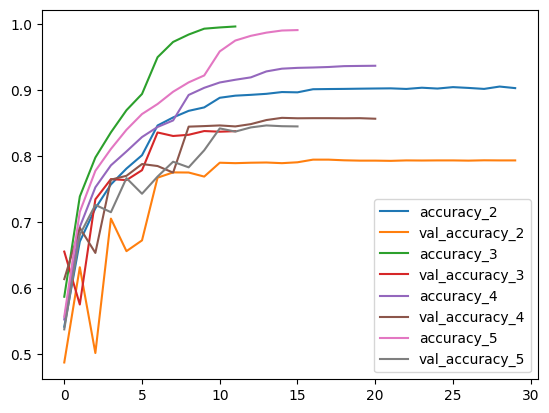

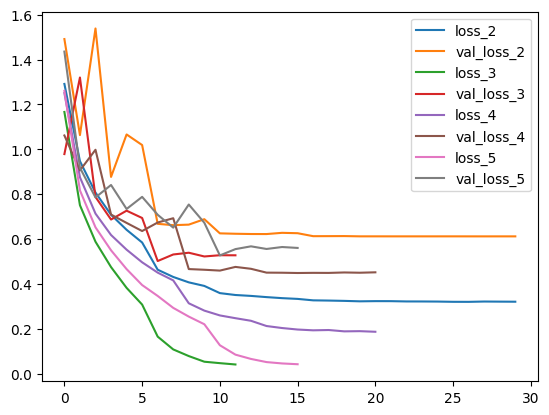

In [ ]:
pd.concat([df_2_acc,df_3_acc,df_4_acc,df_5_acc],axis=1).plot()
pd.concat([df_2_loss,df_3_loss,df_4_loss,df_5_loss],axis=1).plot()

In [ ]:
# model_5.save('model_5.keras')

# with open('history_5', 'wb') as f:
#     pickle.dump(history_5.history, f)

Model 4 is better. Let's try to get better acc on model 4.

#### Model 6 : model 4 with a better classifier

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_6=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_6.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_6=model_6.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.3355 - loss: 1.9978 - val_accuracy: 0.5792 - val_loss: 1.1641 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5977 - loss: 1.1415 - val_accuracy: 0.6628 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6759 - loss: 0.9279 - val_accuracy: 0.7138 - val_loss: 0.8118 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7290 - loss: 0.7842 - val_accuracy: 0.7323 - val_loss: 0.7845 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7621 - loss: 0.6929 - val_accuracy: 0.7542 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7815 - loss: 0.6399 - val_accuracy: 0.7753 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8030 - loss: 0.5

In [ ]:
res_6=model_6.evaluate(batch_test) # 86%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8653 - loss: 0.4180


[0.4270114302635193, 0.8651666641235352]

In [ ]:
df_6 = pd.DataFrame(history_6.history).drop('learning_rate',axis=1)
df_6.columns=['accuracy_6','loss_6','val_accuracy_6','val_loss_6']
df_6_acc=df_6.loc[:,['accuracy_6','val_accuracy_6']]
df_6_loss=df_6.loc[:,['loss_6','val_loss_6']]

<Axes: >

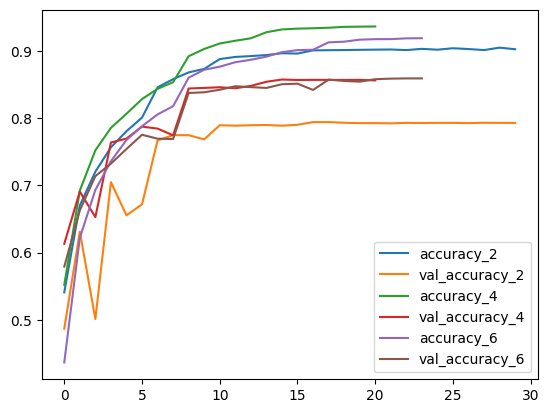

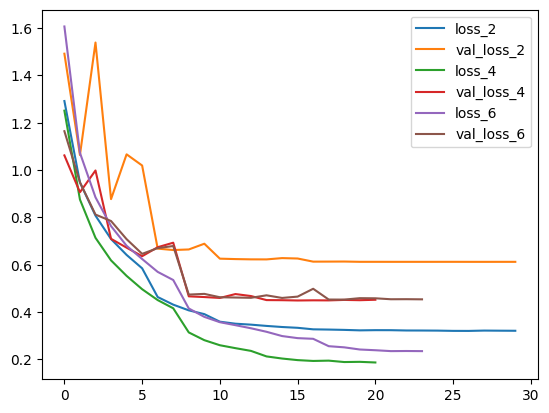

In [ ]:
pd.concat([df_2_acc,df_4_acc,df_6_acc],axis=1).plot()
pd.concat([df_2_loss,df_4_loss,df_6_loss],axis=1).plot()

In [ ]:
# model_6.save('model_6.keras')

# with open('history_6', 'wb') as f:
#     pickle.dump(history_6.history, f)

Very close to model 4, let's try to add a bloc of convolution to model 6 (as it overfit a bit less than model 4)

#### Model 7 : Model 6 + 1 blocs

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_7=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_7.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_7=model_7.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.3372 - loss: 1.9758 - val_accuracy: 0.5398 - val_loss: 1.3026 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6205 - loss: 1.0846 - val_accuracy: 0.6712 - val_loss: 0.9569 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7050 - loss: 0.8676 - val_accuracy: 0.7063 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7461 - loss: 0.7359 - val_accuracy: 0.7500 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7774 - loss: 0.6518 - val_accuracy: 0.7878 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7994 - loss: 0.5856 - val_accuracy: 0.7773 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 7/30
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8232 - loss: 0.

In [ ]:
res_7=model_7.evaluate(batch_test) # 87%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8715 - loss: 0.4227


[0.43344786763191223, 0.8703333139419556]

In [ ]:
df_7=pd.DataFrame(history_7.history).drop('learning_rate',axis=1)
df_7.columns=['accuracy_7','loss_7','val_accuracy_7','val_loss_7']
df_7_acc=df_7.loc[:,['accuracy_7','val_accuracy_7']]
df_7_loss=df_7.loc[:,['loss_7','val_loss_7']]

<Axes: >

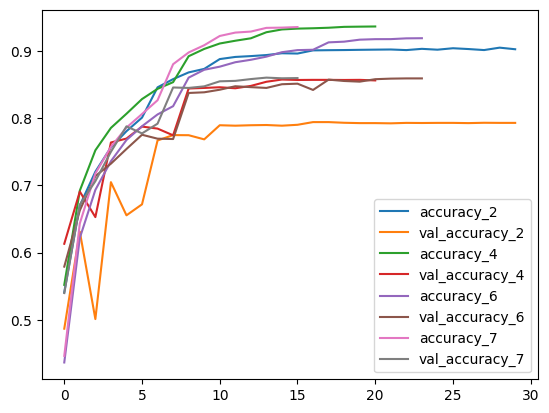

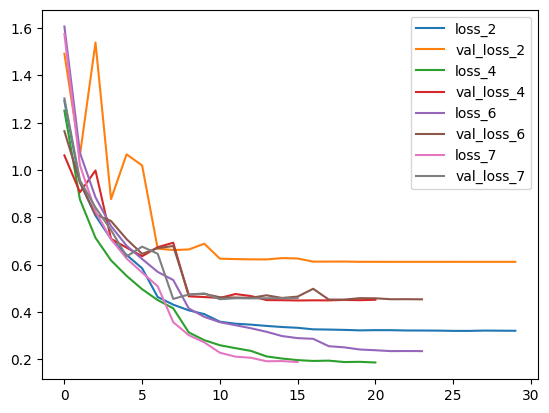

In [ ]:
pd.concat([df_2_acc,df_4_acc,df_6_acc,df_7_acc],axis=1).plot()
pd.concat([df_2_loss,df_4_loss,df_6_loss,df_7_loss],axis=1).plot()

In [ ]:
# model_7.save('model_7.keras')

# with open('history_7', 'wb') as f:
#     pickle.dump(history_7.history, f)

Once again very close to model 4. Let's try AdamW with the weight decay maybe to help with the overfitting and the learning.

#### Model 8 : AdamW decay = 5e-3 (relatively big architecture)

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_8=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu', padding='same'), # Add another bloc
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_8.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.AdamW(weight_decay=0.005),
                metrics=['accuracy'])

history_8=model_8.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.3395 - loss: 1.9836 - val_accuracy: 0.5113 - val_loss: 1.4012 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6133 - loss: 1.1048 - val_accuracy: 0.6148 - val_loss: 1.1733 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6969 - loss: 0.8793 - val_accuracy: 0.6927 - val_loss: 0.9242 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7451 - loss: 0.7456 - val_accuracy: 0.7348 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7769 - loss: 0.6485 - val_accuracy: 0.7793 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8004 - loss: 0.5804 - val_accuracy: 0.7942 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8198 - loss:

In [ ]:
res_8=model_8.evaluate(batch_test) # 87%

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8737 - loss: 0.4199


[0.42337194085121155, 0.8705000281333923]

In [ ]:
df_8=pd.DataFrame(history_8.history).drop('learning_rate',axis=1)
df_8.columns=['accuracy_8','loss_8','val_accuracy_8','val_loss_8']
df_8_acc=df_8.loc[:,['accuracy_8','val_accuracy_8']]
df_8_loss=df_8.loc[:,['loss_8','val_loss_8']]

<Axes: >

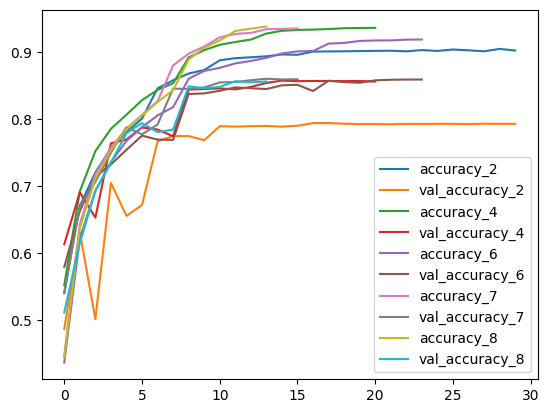

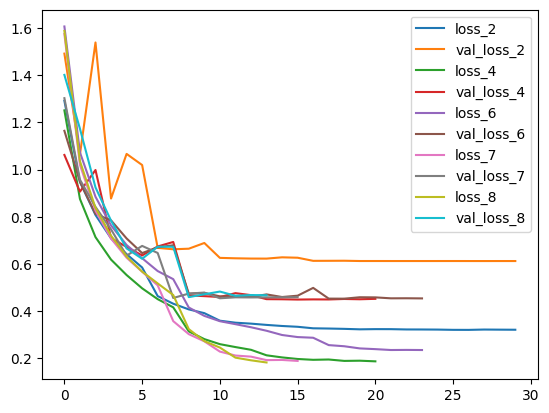

In [ ]:
pd.concat([df_2_acc,df_4_acc,df_6_acc,df_7_acc,df_8_acc],axis=1).plot()
pd.concat([df_2_loss,df_4_loss,df_6_loss,df_7_loss,df_8_loss],axis=1).plot()

In [ ]:
# model_8.save('model_8.keras')

# with open('history_8', 'wb') as f:
#     pickle.dump(history_8.history, f)

Looks like i'm stuck in the performance of my model, let's try a last one with many differences to see if i just don't push enough or if it's really the max i can do.

#### Model 9 : ALL IN

In [ ]:
tf.random.set_seed(42)
random.seed(42)

model_9=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same'), #Un de plus
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'), #Un de plus
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(units=512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
])

model_9.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_9=model_9.fit(batch_train,epochs=30,validation_data=batch_val,callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.1997 - loss: 2.5344 - val_accuracy: 0.4262 - val_loss: 1.5194 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4421 - loss: 1.4915 - val_accuracy: 0.6050 - val_loss: 1.1226 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5909 - loss: 1.1824 - val_accuracy: 0.6145 - val_loss: 1.1357 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6637 - loss: 1.0103 - val_accuracy: 0.7167 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7016 - loss: 0.8990 - val_accuracy: 0.7188 - val_loss: 0.8613 - learning_rate: 0.0010
Epoch 6/30
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7371 - loss: 0.8155
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7371 - loss:

In [ ]:
res_9=model_9.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8652 - loss: 0.4521 


[0.4876953959465027, 0.856166660785675]

In [ ]:
df_9=pd.DataFrame(history_9.history).drop('learning_rate',axis=1)
df_9.columns=['accuracy_9','loss_9','val_accuracy_9','val_loss_9']
df_9_acc=df_9.loc[:,['accuracy_9','val_accuracy_9']]
df_9_loss=df_9.loc[:,['loss_9','val_loss_9']]

<Axes: >

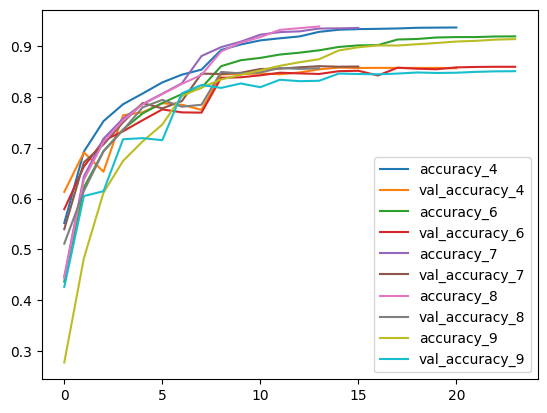

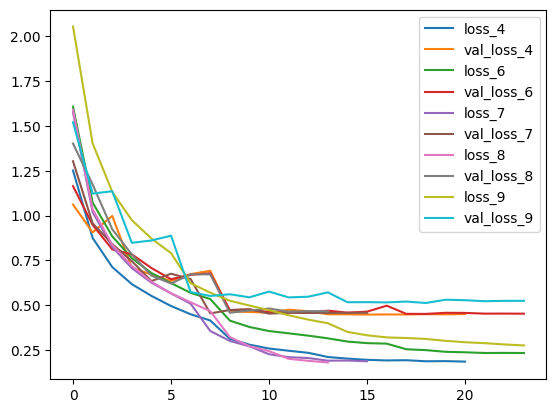

In [ ]:
pd.concat([df_4_acc,df_6_acc,df_7_acc,df_8_acc,df_9_acc],axis=1).plot()
pd.concat([df_4_loss,df_6_loss,df_7_loss,df_8_loss,df_9_loss],axis=1).plot()

In [ ]:
# model_9.save('model_9.keras')

# with open('history_9', 'wb') as f:
#     pickle.dump(history_9.history, f)

Model 9 is bad compared to the other. Let's stop here

## Conclusion :

In [ ]:
res=pd.DataFrame([res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9])
res.columns=['loss','accuracy']
res.index=['model_0','model_1','model_2','model_3','model_4','model_5','model_6','model_7','model_8','model_9']

,loss,accuracy
model_0,0.922684,0.677500
model_1,0.863612,0.703000
model_2,0.550468,0.809667
model_3,0.509614,0.847833
model_4,0.411162,0.868167
model_5,0.530800,0.855500
model_6,0.427013,0.865167
model_7,0.433448,0.870333
model_8,0.423372,0.870500
model_9,0.487696,0.856167


<Axes: >

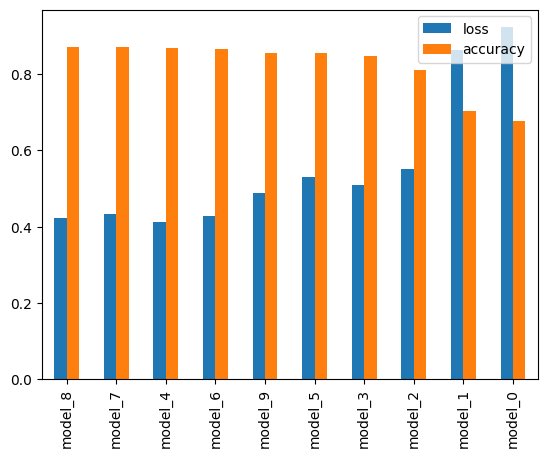

In [ ]:
res.sort_values(by='accuracy',ascending=False).plot(kind='bar')

We will go with model 4 as it is one of the best in accuracy and loss combined and also is (amongst model 8 and 7) the one with the less parameters (3M for 8 and 7 and 800k for 4). We have an accuracy of 86% on test.

### Confusion matrix :

In [82]:
model_4 = tf.keras.models.load_model('model_4.keras')

In [162]:
# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in batch_test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_4.predict(image_batch,verbose=0)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

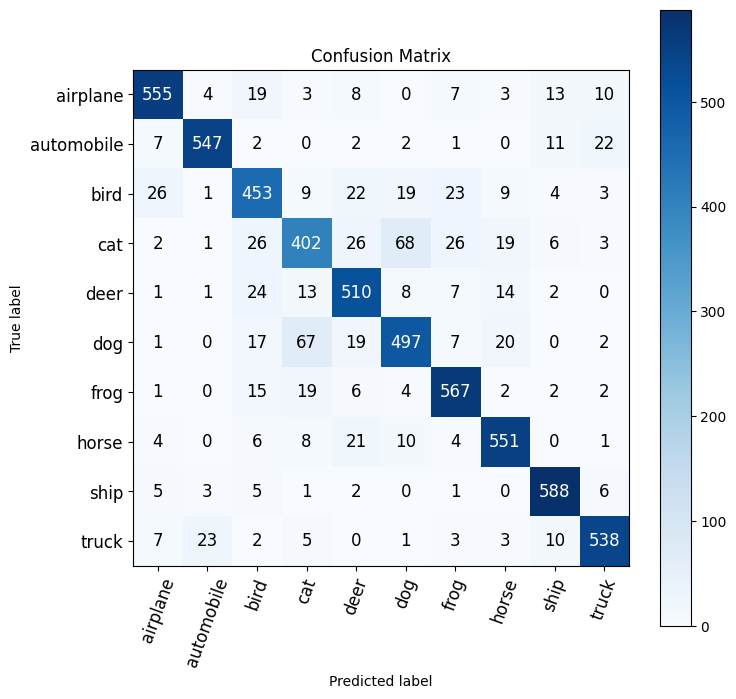

In [166]:
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

n_classes=len(class_names)

cm = confusion_matrix(correct_labels, predicted_labels)

# Plot the figure and make it pretty
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
fig.colorbar(cax)

# Label the axes
ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=class_names,
        yticklabels=class_names)

# Make x-axis labels appear on bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)

# Set the threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]}",
          ha="center",
          va='center',
          color="white" if cm[i, j] > threshold else "black",
          size=12)